<h1 align="center">Allergen Chip Challenge💡</h1>

<h2 align="center">Loading libraries📚</h3>

In [1]:
!pip install xgboost scikit-optimize --quiet

In [2]:
import os
import gc
import pprint
import joblib
from tqdm import tqdm
from time import time
from functools import partial
from scipy.misc import derivative
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import model_selection, metrics  
from xgboost import XGBClassifier, plot_importance

from skopt.utils import use_named_args 
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt import BayesSearchCV

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

<h2 align="center">◀Loading data</h3>

#### I made a seperate notebook for EDA, Pre-Processing and Feature Engineering. This dataset comes from that notebook.
- Please refer to: `1.EDA_and_Pre-Processing.ipynb`

In [3]:
DATA_DIR = './processed_data/'

In [4]:
train = pd.read_csv(os.path.join(DATA_DIR, 'train_processed.csv'), low_memory=False)
test = pd.read_csv(os.path.join(DATA_DIR, 'test_processed.csv'), low_memory=False)
y = pd.read_csv(os.path.join(DATA_DIR, 'Targets.csv'), low_memory=False)

allergen_maps = pd.read_csv(os.path.join(DATA_DIR, 'Allergen_Maps.csv'))

In [5]:
#Let's look at the data
train.head()

,Chip_Type,Age,Gender,Blood_Month_sample,Rural_or_urban_area,Sensitization,Age_of_onsets,Skin_Symptoms,Treatment_of_rhinitis_0,Treatment_of_rhinitis_9,Treatment_of_rhinitis_1,Treatment_of_rhinitis_2,Treatment_of_rhinitis_3,Treatment_of_rhinitis_4,Treatment_of_athsma_0,Treatment_of_athsma_9,Treatment_of_athsma_1,Treatment_of_athsma_2,Treatment_of_athsma_3,Treatment_of_athsma_4,Treatment_of_athsma_5,Treatment_of_athsma_6,Treatment_of_athsma_7,Treatment_of_athsma_8,General_cofactors_0,General_cofactors_1,General_cofactors_2,General_cofactors_3,General_cofactors_4,General_cofactors_5,General_cofactors_6,General_cofactors_7,General_cofactors_8,General_cofactors_10,General_cofactors_11,General_cofactors_12,Treatment_of_atopic_dematitis_0,Treatment_of_atopic_dematitis_9,Treatment_of_atopic_dematitis_1,Treatment_of_atopic_dematitis_2,Treatment_of_atopic_dematitis_3,Treatment_of_atopic_dematitis_4,Treatment_of_atopic_dematitis_5,Treatment_of_atopic_dematitis_7,French_Region_regionA,French_Region_regionB,French_Region_regionC,French_Region_regionD,French_Region_regionE,French_Region_regionF,French_Region_regionG,French_Region_regionH,French_Region_regionI,French_Region_regionJ,French_Region_regionK,French_Region_regionL,French_Region_regionM,French_Region_regionN,French_Region_regionO,Patient_ID_txt_FHB,Patient_ID_txt_GER,Patient_ID_txt_GJH,Patient_ID_txt_HNR,Patient_ID_txt_PCR,Patient_ID_txt_PMP,Patient_ID_txt_QVW,Patient_ID_txt_TFG,Patient_ID_txt_TXV,Patient_ID_txt_WQW,Patient_ID_txt_XPW,row_mean,row_median,row_std,row_max,Missing_values,Zero_counts,Airway_max,Airway_mean,Airway_sum,Airway_median,Airway_std,Airway_Tree_max,Airway_Tree_min,Airway_Tree_mean,Airway_Tree_sum,Airway_Tree_median,Airway_Tree_std,Airway_Mite_max,Airway_Mite_min,Airway_Mite_mean,Airway_Mite_sum,Airway_Mite_median,Airway_Mite_std,Airway_Molds_max,Airway_Molds_min,Airway_Molds_mean,Airway_Molds_sum,Airway_Molds_median,Airway_Molds_std,Airway_Herb_max,Airway_Herb_mean,Airway_Herb_sum,Airway_Herb_median,Airway_Herb_std,Airway_Cockroach_max,Airway_Cockroach_mean,Airway_Cockroach_sum,Airway_Cockroach_median,Airway_Cockroach_std,Airway_Dander_Animals_max,Airway_Dander_Animals_min,Airway_Dander_Animals_mean,Airway_Dander_Animals_sum,Airway_Dander_Animals_median,Airway_Dander_Animals_std,Airway_Gram_max,Airway_Gram_min,Airway_Gram_mean,Airway_Gram_sum,Airway_Gram_median,Airway_Gram_std,Airway_Yeast_max,Airway_Yeast_mean,Airway_Yeast_sum,Airway_Yeast_median,Airway_Yeast_std,Food_max,Food_min,Food_mean,Food_sum,Food_median,Food_std,Food_Fruits_max,Food_Fruits_min,Food_Fruits_mean,Food_Fruits_sum,Food_Fruits_median,Food_Fruits_std,Food_Vegetables_max,Food_Vegetables_min,Food_Vegetables_mean,Food_Vegetables_sum,Food_Vegetables_median,Food_Vegetables_std,Food_Other_max,Food_Other_min,Food_Other_mean,Food_Other_sum,Food_Other_median,Food_Other_std,Food_Tree_Nuts_max,Food_Tree_Nuts_min,Food_Tree_Nuts_mean,Food_Tree_Nuts_sum,Food_Tree_Nuts_median,Food_Tree_Nuts_std,Food_Fish_max,Food_Fish_min,Food_Fish_mean,Food_Fish_sum,Food_Fish_median,Food_Fish_std,Food_Peanut_max,Food_Peanut_min,Food_Peanut_mean,Food_Peanut_sum,Food_Peanut_median,Food_Peanut_std,Food_Cereals_max,Food_Cereals_min,Food_Cereals_mean,Food_Cereals_sum,Food_Cereals_median,Food_Cereals_std,Food_Mammalian_Milk_max,Food_Mammalian_Milk_min,Food_Mammalian_Milk_mean,Food_Mammalian_Milk_sum,Food_Mammalian_Milk_median,Food_Mammalian_Milk_std,Food_Shellfish_max,Food_Shellfish_min,Food_Shellfish_mean,Food_Shellfish_sum,Food_Shellfish_median,Food_Shellfish_std,Food_Seeds_max,Food_Seeds_min,Food_Seeds_mean,Food_Seeds_sum,Food_Seeds_median,Food_Seeds_std,Food_Egg_max,Food_Egg_min,Food_Egg_mean,Food_Egg_sum,Food_Egg_median,Food_Egg_std,Food_Other_Legumes_max,Food_Other_Legumes_min,Food_Other_Legumes_mean,Food_Other_Legumes_sum,Food_Other_Legumes_median,Food_Other_Legumes_std,Food_Aromatics_max,Food_Aromatics_min,Food_Aromatics_mean,Food_Aromatics_sum,Food_Aromatics_median,Food_Aromatics_std,Injection_max,Injection_min,Injecti

In [6]:
test.head()

,Chip_Type,Age,Gender,Blood_Month_sample,Rural_or_urban_area,Sensitization,Age_of_onsets,Skin_Symptoms,Treatment_of_rhinitis_0,Treatment_of_rhinitis_9,Treatment_of_rhinitis_1,Treatment_of_rhinitis_2,Treatment_of_rhinitis_3,Treatment_of_rhinitis_4,Treatment_of_athsma_0,Treatment_of_athsma_9,Treatment_of_athsma_1,Treatment_of_athsma_2,Treatment_of_athsma_3,Treatment_of_athsma_4,Treatment_of_athsma_5,Treatment_of_athsma_6,Treatment_of_athsma_7,Treatment_of_athsma_8,General_cofactors_0,General_cofactors_1,General_cofactors_2,General_cofactors_3,General_cofactors_4,General_cofactors_5,General_cofactors_6,General_cofactors_7,General_cofactors_8,General_cofactors_10,General_cofactors_11,General_cofactors_12,Treatment_of_atopic_dematitis_0,Treatment_of_atopic_dematitis_9,Treatment_of_atopic_dematitis_1,Treatment_of_atopic_dematitis_2,Treatment_of_atopic_dematitis_3,Treatment_of_atopic_dematitis_4,Treatment_of_atopic_dematitis_5,Treatment_of_atopic_dematitis_7,French_Region_regionA,French_Region_regionB,French_Region_regionC,French_Region_regionD,French_Region_regionE,French_Region_regionF,French_Region_regionG,French_Region_regionH,French_Region_regionI,French_Region_regionJ,French_Region_regionK,French_Region_regionL,French_Region_regionM,French_Region_regionN,French_Region_regionO,Patient_ID_txt_FHB,Patient_ID_txt_GER,Patient_ID_txt_GJH,Patient_ID_txt_HNR,Patient_ID_txt_PCR,Patient_ID_txt_PMP,Patient_ID_txt_QVW,Patient_ID_txt_TFG,Patient_ID_txt_TXV,Patient_ID_txt_WQW,Patient_ID_txt_XPW,row_mean,row_median,row_std,row_max,Missing_values,Zero_counts,Airway_max,Airway_mean,Airway_sum,Airway_median,Airway_std,Airway_Tree_max,Airway_Tree_min,Airway_Tree_mean,Airway_Tree_sum,Airway_Tree_median,Airway_Tree_std,Airway_Mite_max,Airway_Mite_min,Airway_Mite_mean,Airway_Mite_sum,Airway_Mite_median,Airway_Mite_std,Airway_Molds_max,Airway_Molds_min,Airway_Molds_mean,Airway_Molds_sum,Airway_Molds_median,Airway_Molds_std,Airway_Herb_max,Airway_Herb_mean,Airway_Herb_sum,Airway_Herb_median,Airway_Herb_std,Airway_Cockroach_max,Airway_Cockroach_mean,Airway_Cockroach_sum,Airway_Cockroach_median,Airway_Cockroach_std,Airway_Dander_Animals_max,Airway_Dander_Animals_min,Airway_Dander_Animals_mean,Airway_Dander_Animals_sum,Airway_Dander_Animals_median,Airway_Dander_Animals_std,Airway_Gram_max,Airway_Gram_min,Airway_Gram_mean,Airway_Gram_sum,Airway_Gram_median,Airway_Gram_std,Airway_Yeast_max,Airway_Yeast_mean,Airway_Yeast_sum,Airway_Yeast_median,Airway_Yeast_std,Food_max,Food_min,Food_mean,Food_sum,Food_median,Food_std,Food_Fruits_max,Food_Fruits_min,Food_Fruits_mean,Food_Fruits_sum,Food_Fruits_median,Food_Fruits_std,Food_Vegetables_max,Food_Vegetables_min,Food_Vegetables_mean,Food_Vegetables_sum,Food_Vegetables_median,Food_Vegetables_std,Food_Other_max,Food_Other_min,Food_Other_mean,Food_Other_sum,Food_Other_median,Food_Other_std,Food_Tree_Nuts_max,Food_Tree_Nuts_min,Food_Tree_Nuts_mean,Food_Tree_Nuts_sum,Food_Tree_Nuts_median,Food_Tree_Nuts_std,Food_Fish_max,Food_Fish_min,Food_Fish_mean,Food_Fish_sum,Food_Fish_median,Food_Fish_std,Food_Peanut_max,Food_Peanut_min,Food_Peanut_mean,Food_Peanut_sum,Food_Peanut_median,Food_Peanut_std,Food_Cereals_max,Food_Cereals_min,Food_Cereals_mean,Food_Cereals_sum,Food_Cereals_median,Food_Cereals_std,Food_Mammalian_Milk_max,Food_Mammalian_Milk_min,Food_Mammalian_Milk_mean,Food_Mammalian_Milk_sum,Food_Mammalian_Milk_median,Food_Mammalian_Milk_std,Food_Shellfish_max,Food_Shellfish_min,Food_Shellfish_mean,Food_Shellfish_sum,Food_Shellfish_median,Food_Shellfish_std,Food_Seeds_max,Food_Seeds_min,Food_Seeds_mean,Food_Seeds_sum,Food_Seeds_median,Food_Seeds_std,Food_Egg_max,Food_Egg_min,Food_Egg_mean,Food_Egg_sum,Food_Egg_median,Food_Egg_std,Food_Other_Legumes_max,Food_Other_Legumes_min,Food_Other_Legumes_mean,Food_Other_Legumes_sum,Food_Other_Legumes_median,Food_Other_Legumes_std,Food_Aromatics_max,Food_Aromatics_min,Food_Aromatics_mean,Food_Aromatics_sum,Food_Aromatics_median,Food_Aromatics_std,Injection_max,Injection_min,Injecti

In [7]:
train.shape, y.shape, test.shape, allergen_maps.shape

((1355, 216), (1355, 29), (586, 216), (305, 3))

In [8]:
y.head()

,Allergy_Present,Severe_Allergy,Respiratory_Allergy,Food_Allergy,Venom_Allergy,Type_of_Respiratory_Allergy_ARIA,Type_of_Respiratory_Allergy_CONJ,Type_of_Respiratory_Allergy_GINA,Type_of_Respiratory_Allergy_IGE_Pollen_Gram,Type_of_Respiratory_Allergy_IGE_Pollen_Herb,Type_of_Respiratory_Allergy_IGE_Pollen_Tree,Type_of_Respiratory_Allergy_IGE_Dander_Animals,Type_of_Respiratory_Allergy_IGE_Mite_Cockroach,Type_of_Respiratory_Allergy_IGE_Molds_Yeast,Type_of_Food_Allergy_Aromatics,Type_of_Food_Allergy_Other,Type_of_Food_Allergy_Cereals_&_Seeds,Type_of_Food_Allergy_Egg,Type_of_Food_Allergy_Fish,Type_of_Food_Allergy_Fruits_and_Vegetables,Type_of_Food_Allergy_Mammalian_Milk,Type_of_Food_Allergy_Oral_Syndrom,Type_of_Food_Allergy_Other_Legumes,Type_of_Food_Allergy_Peanut,Type_of_Food_Allergy_Shellfish,Type_of_Food_Allergy_TPO,Type_of_Food_Allergy_Tree_Nuts,Type_of_Venom_Allergy_ATCD_Venom,Type_of_Venom_Allergy_IGE_Venom
0,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# Let's see some stats
train.describe()

,Chip_Type,Age,Gender,Blood_Month_sample,Rural_or_urban_area,Sensitization,Age_of_onsets,Skin_Symptoms,Treatment_of_rhinitis_0,Treatment_of_rhinitis_9,Treatment_of_rhinitis_1,Treatment_of_rhinitis_2,Treatment_of_rhinitis_3,Treatment_of_rhinitis_4,Treatment_of_athsma_0,Treatment_of_athsma_9,Treatment_of_athsma_1,Treatment_of_athsma_2,Treatment_of_athsma_3,Treatment_of_athsma_4,Treatment_of_athsma_5,Treatment_of_athsma_6,Treatment_of_athsma_7,Treatment_of_athsma_8,General_cofactors_0,General_cofactors_1,General_cofactors_2,General_cofactors_3,General_cofactors_4,General_cofactors_5,General_cofactors_6,General_cofactors_7,General_cofactors_8,General_cofactors_10,General_cofactors_11,General_cofactors_12,Treatment_of_atopic_dematitis_0,Treatment_of_atopic_dematitis_9,Treatment_of_atopic_dematitis_1,Treatment_of_atopic_dematitis_2,Treatment_of_atopic_dematitis_3,Treatment_of_atopic_dematitis_4,Treatment_of_atopic_dematitis_5,Treatment_of_atopic_dematitis_7,French_Region_regionA,French_Region_regionB,French_Region_regionC,French_Region_regionD,French_Region_regionE,French_Region_regionF,French_Region_regionG,French_Region_regionH,French_Region_regionI,French_Region_regionJ,French_Region_regionK,French_Region_regionL,French_Region_regionM,French_Region_regionN,French_Region_regionO,Patient_ID_txt_FHB,Patient_ID_txt_GER,Patient_ID_txt_GJH,Patient_ID_txt_HNR,Patient_ID_txt_PCR,Patient_ID_txt_PMP,Patient_ID_txt_QVW,Patient_ID_txt_TFG,Patient_ID_txt_TXV,Patient_ID_txt_WQW,Patient_ID_txt_XPW,row_mean,row_median,row_std,row_max,Missing_values,Zero_counts,Airway_max,Airway_mean,Airway_sum,Airway_median,Airway_std,Airway_Tree_max,Airway_Tree_min,Airway_Tree_mean,Airway_Tree_sum,Airway_Tree_median,Airway_Tree_std,Airway_Mite_max,Airway_Mite_min,Airway_Mite_mean,Airway_Mite_sum,Airway_Mite_median,Airway_Mite_std,Airway_Molds_max,Airway_Molds_min,Airway_Molds_mean,Airway_Molds_sum,Airway_Molds_median,Airway_Molds_std,Airway_Herb_max,Airway_Herb_mean,Airway_Herb_sum,Airway_Herb_median,Airway_Herb_std,Airway_Cockroach_max,Airway_Cockroach_mean,Airway_Cockroach_sum,Airway_Cockroach_median,Airway_Cockroach_std,Airway_Dander_Animals_max,Airway_Dander_Animals_min,Airway_Dander_Animals_mean,Airway_Dander_Animals_sum,Airway_Dander_Animals_median,Airway_Dander_Animals_std,Airway_Gram_max,Airway_Gram_min,Airway_Gram_mean,Airway_Gram_sum,Airway_Gram_median,Airway_Gram_std,Airway_Yeast_max,Airway_Yeast_mean,Airway_Yeast_sum,Airway_Yeast_median,Airway_Yeast_std,Food_max,Food_min,Food_mean,Food_sum,Food_median,Food_std,Food_Fruits_max,Food_Fruits_min,Food_Fruits_mean,Food_Fruits_sum,Food_Fruits_median,Food_Fruits_std,Food_Vegetables_max,Food_Vegetables_min,Food_Vegetables_mean,Food_Vegetables_sum,Food_Vegetables_median,Food_Vegetables_std,Food_Other_max,Food_Other_min,Food_Other_mean,Food_Other_sum,Food_Other_median,Food_Other_std,Food_Tree_Nuts_max,Food_Tree_Nuts_min,Food_Tree_Nuts_mean,Food_Tree_Nuts_sum,Food_Tree_Nuts_median,Food_Tree_Nuts_std,Food_Fish_max,Food_Fish_min,Food_Fish_mean,Food_Fish_sum,Food_Fish_median,Food_Fish_std,Food_Peanut_max,Food_Peanut_min,Food_Peanut_mean,Food_Peanut_sum,Food_Peanut_median,Food_Peanut_std,Food_Cereals_max,Food_Cereals_min,Food_Cereals_mean,Food_Cereals_sum,Food_Cereals_median,Food_Cereals_std,Food_Mammalian_Milk_max,Food_Mammalian_Milk_min,Food_Mammalian_Milk_mean,Food_Mammalian_Milk_sum,Food_Mammalian_Milk_median,Food_Mammalian_Milk_std,Food_Shellfish_max,Food_Shellfish_min,Food_Shellfish_mean,Food_Shellfish_sum,Food_Shellfish_median,Food_Shellfish_std,Food_Seeds_max,Food_Seeds_min,Food_Seeds_mean,Food_Seeds_sum,Food_Seeds_median,Food_Seeds_std,Food_Egg_max,Food_Egg_min,Food_Egg_mean,Food_Egg_sum,Food_Egg_median,Food_Egg_std,Food_Other_Legumes_max,Food_Other_Legumes_min,Food_Other_Legumes_mean,Food_Other_Legumes_sum,Food_Other_Legumes_median,Food_Other_Legumes_std,Food_Aromatics_max,Food_Aromatics_min,Food_Aromatics_mean,Food_Aromatics_sum,Food_Aromatics_median,Food_Aromatics_std,Injection_max,Injection_min,Injecti

In [10]:
test.describe()

,Chip_Type,Age,Gender,Blood_Month_sample,Rural_or_urban_area,Sensitization,Age_of_onsets,Skin_Symptoms,Treatment_of_rhinitis_0,Treatment_of_rhinitis_9,Treatment_of_rhinitis_1,Treatment_of_rhinitis_2,Treatment_of_rhinitis_3,Treatment_of_rhinitis_4,Treatment_of_athsma_0,Treatment_of_athsma_9,Treatment_of_athsma_1,Treatment_of_athsma_2,Treatment_of_athsma_3,Treatment_of_athsma_4,Treatment_of_athsma_5,Treatment_of_athsma_6,Treatment_of_athsma_7,Treatment_of_athsma_8,General_cofactors_0,General_cofactors_1,General_cofactors_2,General_cofactors_3,General_cofactors_4,General_cofactors_5,General_cofactors_6,General_cofactors_7,General_cofactors_8,General_cofactors_10,General_cofactors_11,General_cofactors_12,Treatment_of_atopic_dematitis_0,Treatment_of_atopic_dematitis_9,Treatment_of_atopic_dematitis_1,Treatment_of_atopic_dematitis_2,Treatment_of_atopic_dematitis_3,Treatment_of_atopic_dematitis_4,Treatment_of_atopic_dematitis_5,Treatment_of_atopic_dematitis_7,French_Region_regionA,French_Region_regionB,French_Region_regionC,French_Region_regionD,French_Region_regionE,French_Region_regionF,French_Region_regionG,French_Region_regionH,French_Region_regionI,French_Region_regionJ,French_Region_regionK,French_Region_regionL,French_Region_regionM,French_Region_regionN,French_Region_regionO,Patient_ID_txt_FHB,Patient_ID_txt_GER,Patient_ID_txt_GJH,Patient_ID_txt_HNR,Patient_ID_txt_PCR,Patient_ID_txt_PMP,Patient_ID_txt_QVW,Patient_ID_txt_TFG,Patient_ID_txt_TXV,Patient_ID_txt_WQW,Patient_ID_txt_XPW,row_mean,row_median,row_std,row_max,Missing_values,Zero_counts,Airway_max,Airway_mean,Airway_sum,Airway_median,Airway_std,Airway_Tree_max,Airway_Tree_min,Airway_Tree_mean,Airway_Tree_sum,Airway_Tree_median,Airway_Tree_std,Airway_Mite_max,Airway_Mite_min,Airway_Mite_mean,Airway_Mite_sum,Airway_Mite_median,Airway_Mite_std,Airway_Molds_max,Airway_Molds_min,Airway_Molds_mean,Airway_Molds_sum,Airway_Molds_median,Airway_Molds_std,Airway_Herb_max,Airway_Herb_mean,Airway_Herb_sum,Airway_Herb_median,Airway_Herb_std,Airway_Cockroach_max,Airway_Cockroach_mean,Airway_Cockroach_sum,Airway_Cockroach_median,Airway_Cockroach_std,Airway_Dander_Animals_max,Airway_Dander_Animals_min,Airway_Dander_Animals_mean,Airway_Dander_Animals_sum,Airway_Dander_Animals_median,Airway_Dander_Animals_std,Airway_Gram_max,Airway_Gram_min,Airway_Gram_mean,Airway_Gram_sum,Airway_Gram_median,Airway_Gram_std,Airway_Yeast_max,Airway_Yeast_mean,Airway_Yeast_sum,Airway_Yeast_median,Airway_Yeast_std,Food_max,Food_min,Food_mean,Food_sum,Food_median,Food_std,Food_Fruits_max,Food_Fruits_min,Food_Fruits_mean,Food_Fruits_sum,Food_Fruits_median,Food_Fruits_std,Food_Vegetables_max,Food_Vegetables_min,Food_Vegetables_mean,Food_Vegetables_sum,Food_Vegetables_median,Food_Vegetables_std,Food_Other_max,Food_Other_min,Food_Other_mean,Food_Other_sum,Food_Other_median,Food_Other_std,Food_Tree_Nuts_max,Food_Tree_Nuts_min,Food_Tree_Nuts_mean,Food_Tree_Nuts_sum,Food_Tree_Nuts_median,Food_Tree_Nuts_std,Food_Fish_max,Food_Fish_min,Food_Fish_mean,Food_Fish_sum,Food_Fish_median,Food_Fish_std,Food_Peanut_max,Food_Peanut_min,Food_Peanut_mean,Food_Peanut_sum,Food_Peanut_median,Food_Peanut_std,Food_Cereals_max,Food_Cereals_min,Food_Cereals_mean,Food_Cereals_sum,Food_Cereals_median,Food_Cereals_std,Food_Mammalian_Milk_max,Food_Mammalian_Milk_min,Food_Mammalian_Milk_mean,Food_Mammalian_Milk_sum,Food_Mammalian_Milk_median,Food_Mammalian_Milk_std,Food_Shellfish_max,Food_Shellfish_min,Food_Shellfish_mean,Food_Shellfish_sum,Food_Shellfish_median,Food_Shellfish_std,Food_Seeds_max,Food_Seeds_min,Food_Seeds_mean,Food_Seeds_sum,Food_Seeds_median,Food_Seeds_std,Food_Egg_max,Food_Egg_min,Food_Egg_mean,Food_Egg_sum,Food_Egg_median,Food_Egg_std,Food_Other_Legumes_max,Food_Other_Legumes_min,Food_Other_Legumes_mean,Food_Other_Legumes_sum,Food_Other_Legumes_median,Food_Other_Legumes_std,Food_Aromatics_max,Food_Aromatics_min,Food_Aromatics_mean,Food_Aromatics_sum,Food_Aromatics_median,Food_Aromatics_std,Injection_max,Injection_min,Injecti

In [11]:
allergen_maps.head()

,Allergen,Source,Route
0,Aca_m,Tree,Airway
1,Aca_s,Mite,Airway
2,Ach_d,Other,Food
3,Act_d_1,Fruits,Food
4,Act_d_10,Fruits,Food


In [12]:
train[train < 0] = 0
test[test < 0] = 0

In [13]:
target_columns = y.columns

In [14]:
idx = train.columns.get_loc('Zero_counts')

In [15]:
sub_df_maps = {
    'Allergy_Present': train.columns[idx+1:].tolist(),
    'Severe_Allergy': train.columns[idx+1:].tolist(),
    'Respiratory_Allergy': train.filter(like='Airway').columns.tolist(),
    'Type_of_Respiratory_Allergy_ARIA': train.filter(like='Airway').columns.tolist() + \
                                        train.filter(like='Injection').columns.tolist(),
    'Type_of_Respiratory_Allergy_CONJ': train.filter(like='Airway').columns.tolist() + \
                                        train.filter(like='Injection').columns.tolist(),
    'Type_of_Respiratory_Allergy_GINA': train.filter(like='Airway').columns.tolist() + \
                                        train.filter(like='Injection').columns.tolist(),
    'Type_of_Respiratory_Allergy_IGE_Pollen_Gram': train.filter(like='Airway').columns.tolist(),
    'Type_of_Respiratory_Allergy_IGE_Pollen_Herb': train.filter(like='Airway').columns.tolist(),
    'Type_of_Respiratory_Allergy_IGE_Pollen_Tree': train.filter(like='Airway').columns.tolist(),
    'Type_of_Respiratory_Allergy_IGE_Dander_Animals': train.filter(like='Airway').columns.tolist(),
    'Type_of_Respiratory_Allergy_IGE_Mite_Cockroach': train.filter(like='Airway').columns.tolist(),
    'Type_of_Respiratory_Allergy_IGE_Molds_Yeast': train.filter(like='Airway').columns.tolist(),
    
    'Food_Allergy': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Aromatics': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Other': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Cereals_&_Seeds': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Egg':train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Fish': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Fruits_and_Vegetables': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Mammalian_Milk': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Oral_Syndrom': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Other_Legumes': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Peanut': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Shellfish': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_TPO': train.filter(like='Food').columns.tolist(),
    'Type_of_Food_Allergy_Tree_Nuts': train.filter(like='Food').columns.tolist(),
    
    'Venom_Allergy': train.filter(like='Injection').columns.tolist(),
    'Type_of_Venom_Allergy_ATCD_Venom': train.filter(like='Injection').columns.tolist(),
    'Type_of_Venom_Allergy_IGE_Venom': train.filter(like='Injection').columns.tolist(),
}

In [16]:
# Select subset of Dataset that corresponding to a particular allergy type.
def get_sub_df_for_route(df, col): 
    return df.loc[:, train.columns[0:idx+1].tolist() + sub_df_maps[col]]

<h2 align="center">XGBoost Model Tuning and Training🏋️‍♂️</h3>

#### I have decided to build seperate model for each target variable. There are two reasons for it.
- I tried training `ChainClassifier` model, but NOT performed better when compared with individual models on LB.
- The targets themselves doesn't necessarily correlated. i.e. `Presence of some allergy doesn't imply presence or absence of other`. And there are some instances where `allergy_present = 1` but rest of the target columns have `0`. This is also clarified in discussion.

##### Getting Weights to handle Imbalanced data

In [17]:
scale_pos_weights_all = {}
for col in tqdm(target_columns):
    value_counts = y[col].value_counts(dropna=False).values
    if len(value_counts) == 2: #Having atleast two classes
        scale_pos_weights_all[col] = value_counts[0] / value_counts[1]  #For passing it to `scale_pos_weight` parameter
    else: #Having only one class
        scale_pos_weights_all[col] = value_counts[0]

100%|██████████| 29/29 [00:00<00:00, 3162.06it/s]


##### Hyper Parameter tuning with Bayesian Optimization

In [18]:
# # Reporting util for different optimizers
# def report_perf(optimizer, X, y, title = 'model', callbacks = None):
#     start = time()
#     if callbacks is not None:
#         optimizer.fit(X, y, callback=callbacks)
#     else:
#         optimizer.fit(X, y)
        
#     d=pd.DataFrame(optimizer.cv_results_)
#     best_score = optimizer.best_score_
#     best_score_std = d.iloc[optimizer.best_index_].std_test_score
#     best_params = optimizer.best_params_
    
#     print((title + ' took %.2f seconds, candidates checked: %d, best CV score: %.3f' + u' \u00B1'+' %.3f') % 
#                              (time() - start,
#                              len(optimizer.cv_results_['params']),
#                              best_score, 
#                              best_score_std))
#     print('Best parameters:')
#     pprint.pprint(best_params)
#     print()
#     return best_params

In [19]:
# scoring = metrics.make_scorer(metrics.f1_score, greater_is_better=True)
# rskf = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=3)

# overdone_control = DeltaYStopper(delta=0.0001)
# time_limit_control = DeadlineStopper(total_time=60 * 60 * 7)

# # Setting the search space
# search_spaces = {
#     'learning_rate': Real(0.01, 1.0, 'log-uniform'),     
#     'n_estimators': Integer(100, 1000),                   
#     'max_depth': Integer(1, 12),                      
#     'subsample': Real(0.01, 1.0, 'uniform'),          
#     'colsample_bytree': Real(1, 10, 'uniform'),               
#     'colsample_bylevel': Real(0.01, 1.0, 'uniform'),  
#     'reg_lambda': Real(1e-3, 30.0, 'log-uniform'),
#     'reg_alpha': Real(1e-3, 30.0, 'log-uniform'),
#     'min_child_weight': Real(1, 30, 'log-uniform'),
#    }

In [20]:
# def tune_model(target_col):
#     target = y[target_col].values
#     X_final = get_sub_df_for_route(train, target_col)
        
#     model = XGBClassifier(random_state=3, scale_pos_weight = scale_pos_weights_)
#     opt = BayesSearchCV(estimator=model, search_spaces=search_spaces, scoring=scoring, cv=rskf, n_iter=50, n_jobs=4,
#                     iid=False, return_train_score=False, refit=True, optimizer_kwargs={'base_estimator': 'GBRT'},
#                     random_state=3)
#     best_params = report_perf(opt, X_final, target, 'XGBoost', callbacks=[overdone_control, time_limit_control])
    
#     return {key:value for key, value in best_params.items()}

In [21]:
# # Uncomment to tune the model again.
# best_params_for_all_targets = {}
# for col in target_columns:
#     print(f'\n################ Tuning for {col} ####################')
#     scale_pos_weights_ = scale_pos_weights_all[col]  #To deal with Imbalanced data
#     best_params_for_all_targets[col] = tune_model(col)
#     best_params_for_all_targets[col].update({'random_state': 3, 'scale_pos_weight': scale_pos_weights_})

In [22]:
# best_params_for_all_targets

##### Best Parameters 

In [23]:
# CAREFUL: Don't change these for reproducibility.
best_params_for_all_targets = {'Allergy_Present': {'colsample_bytree': 0.9303256446537502,
  'learning_rate': 0.05165001015018447,
  'max_depth': 5,
  'min_child_weight': 1.0,
  'n_estimators': 313,
  'reg_alpha': 0.042522040694628664,
  'reg_lambda': 0.13183247847074198,
  'subsample': 1.0,
  'random_state': 3,
  'scale_pos_weight': 4.770212765957447},
 'Severe_Allergy': {'colsample_bytree': 0.5594332390716024,
  'learning_rate': 0.19956675778230745,
  'max_depth': 5,
  'min_child_weight': 1.8445856124098645,
  'n_estimators': 374,
  'reg_alpha': 0.7334034778097713,
  'reg_lambda': 0.0012002534170905393,
  'subsample': 0.7093641524683441,
  'random_state': 3,
  'scale_pos_weight': 2.2440191387559807},
 'Respiratory_Allergy': {'colsample_bytree': 1.0,
  'learning_rate': 0.01,
  'max_depth': 9,
  'min_child_weight': 1.7131490596717158,
  'n_estimators': 453,
  'reg_alpha': 0.001,
  'reg_lambda': 0.0026159100676186767,
  'subsample': 0.7512512011942954,
  'random_state': 3,
  'scale_pos_weight': 3.0843373493975905},
 'Type_of_Respiratory_Allergy_ARIA': {'colsample_bytree': 1.0,
  'learning_rate': 0.3158875476605416,
  'max_depth': 6,
  'min_child_weight': 1.6726111944392419,
  'n_estimators': 157,
  'reg_alpha': 5.871673965940205,
  'reg_lambda': 0.17443164426346405,
  'subsample': 0.8042567760129212,
  'random_state': 3,
  'scale_pos_weight': 1.2156862745098038},
 'Type_of_Respiratory_Allergy_CONJ': {'colsample_bytree': 0.6817883488282243,
  'learning_rate': 0.01,
  'max_depth': 5,
  'min_child_weight': 1.0,
  'n_estimators': 356,
  'reg_alpha': 0.001,
  'reg_lambda': 8.391539052584598,
  'subsample': 1.0,
  'random_state': 3,
  'scale_pos_weight': 2.635388739946381},
 'Type_of_Respiratory_Allergy_GINA': {'colsample_bytree': 0.863402779634215,
  'learning_rate': 0.08943138320802868,
  'max_depth': 1,
  'min_child_weight': 3.6602365912843666,
  'n_estimators': 500,
  'reg_alpha': 2.7197515046964944,
  'reg_lambda': 0.03492688448556529,
  'subsample': 0.7603670258533833,
  'random_state': 3,
  'scale_pos_weight': 1.0452488687782806},
 'Type_of_Respiratory_Allergy_IGE_Pollen_Gram': {'colsample_bytree': 1.0,
  'learning_rate': 0.015439307265811948,
  'max_depth': 10,
  'min_child_weight': 3.0554168894356204,
  'n_estimators': 100,
  'reg_alpha': 0.0038482866066581038,
  'reg_lambda': 18.65135988128213,
  'subsample': 1.0,
  'random_state': 3,
  'scale_pos_weight': 1.1558028616852147},
 'Type_of_Respiratory_Allergy_IGE_Pollen_Herb': {'colsample_bytree': 0.9674599126354568,
  'learning_rate': 0.3259160979601883,
  'max_depth': 6,
  'min_child_weight': 1.8715557948362902,
  'n_estimators': 195,
  'reg_alpha': 6.836790148416063,
  'reg_lambda': 0.1011679517962163,
  'subsample': 0.7205601867045284,
  'random_state': 3,
  'scale_pos_weight': 2.2440191387559807},
 'Type_of_Respiratory_Allergy_IGE_Pollen_Tree': {'colsample_bytree': 0.9962498766874971,
  'learning_rate': 0.11840513860888005,
  'max_depth': 7,
  'min_child_weight': 1.4071691023514248,
  'n_estimators': 132,
  'reg_alpha': 0.19709077709812914,
  'reg_lambda': 0.012893431020412576,
  'subsample': 0.9926006439033178,
  'random_state': 3,
  'scale_pos_weight': 1.1906300484652665},
 'Type_of_Respiratory_Allergy_IGE_Dander_Animals': {'colsample_bytree': 0.5102436487045892,
  'learning_rate': 0.45114736580367026,
  'max_depth': 7,
  'min_child_weight': 3.4741978657730854,
  'n_estimators': 383,
  'reg_alpha': 0.03580247420665012,
  'reg_lambda': 0.7792379168456626,
  'subsample': 0.9520613047299374,
  'random_state': 3,
  'scale_pos_weight': 1.321917808219178},
 'Type_of_Respiratory_Allergy_IGE_Mite_Cockroach': {'colsample_bytree': 1.0,
  'learning_rate': 1.0,
  'max_depth': 12,
  'min_child_weight': 1.0,
  'n_estimators': 100,
  'reg_alpha': 0.001,
  'reg_lambda': 30.0,
  'subsample': 1.0,
  'random_state': 3,
  'scale_pos_weight': 1.2751677852348993},
 'Type_of_Respiratory_Allergy_IGE_Molds_Yeast': {'colsample_bytree': 0.9585662367482223,
  'learning_rate': 0.05712303282707687,
  'max_depth': 12,
  'min_child_weight': 1.0,
  'n_estimators': 145,
  'reg_alpha': 0.002026054040610966,
  'reg_lambda': 0.21564139476387154,
  'subsample': 0.8342207332537538,
  'random_state': 3,
  'scale_pos_weight': 3.4900662251655628},
 'Food_Allergy': {'colsample_bytree': 0.6829653512486914,
  'learning_rate': 0.018722976788007828,
  'max_depth': 3,
  'min_child_weight': 1.8173133998355306,
  'n_estimators': 232,
  'reg_alpha': 0.3418875056597497,
  'reg_lambda': 0.5580889086656272,
  'subsample': 0.4105289793654779,
  'random_state': 3,
  'scale_pos_weight': 1.2562396006655574},
 'Type_of_Food_Allergy_Aromatics': {'colsample_bytree': 0.3408725617189997,
  'learning_rate': 0.24866786258246837,
  'max_depth': 1,
  'min_child_weight': 25.843961943775263,
  'n_estimators': 192,
  'reg_alpha': 23.42022234252057,
  'reg_lambda': 0.001,
  'subsample': 0.608226608900368,
  'random_state': 3,
  'scale_pos_weight': 38.88235294117647},
 'Type_of_Food_Allergy_Other': {'colsample_bytree': 0.5356545233026259,
  'learning_rate': 0.22498782522548938,
  'max_depth': 8,
  'min_child_weight': 9.020376938087601,
  'n_estimators': 443,
  'reg_alpha': 24.551005584236307,
  'reg_lambda': 0.0037443712608664953,
  'subsample': 0.01162059109844919,
  'random_state': 3,
  'scale_pos_weight': 1356},
 'Type_of_Food_Allergy_Cereals_&_Seeds': {'colsample_bytree': 0.5356545233026259,
  'learning_rate': 0.22498782522548938,
  'max_depth': 8,
  'min_child_weight': 9.020376938087601,
  'n_estimators': 443,
  'reg_alpha': 24.551005584236307,
  'reg_lambda': 0.0037443712608664953,
  'subsample': 0.01162059109844919,
  'random_state': 3,
  'scale_pos_weight': 1356},
 'Type_of_Food_Allergy_Egg': {'colsample_bytree': 0.5410444816968727,
  'learning_rate': 0.016934867656023457,
  'max_depth': 6,
  'min_child_weight': 11.02537448648772,
  'n_estimators': 384,
  'reg_alpha': 0.060550101881016616,
  'reg_lambda': 0.6481244166210908,
  'subsample': 0.5712907454858045,
  'random_state': 3,
  'scale_pos_weight': 31.285714285714285},
 'Type_of_Food_Allergy_Fish': {'colsample_bytree': 0.6527309370003682,
  'learning_rate': 0.01,
  'max_depth': 10,
  'min_child_weight': 3.288591844581428,
  'n_estimators': 500,
  'reg_alpha': 30.0,
  'reg_lambda': 0.001,
  'subsample': 0.7624606278696816,
  'random_state': 3,
  'scale_pos_weight': 34.68421052631579},
 'Type_of_Food_Allergy_Fruits_and_Vegetables': {'colsample_bytree': 1.0,
  'learning_rate': 0.01,
  'max_depth': 12,
  'min_child_weight': 1.0,
  'n_estimators': 481,
  'reg_alpha': 30.0,
  'reg_lambda': 0.001,
  'subsample': 0.8726634213836665,
  'random_state': 3,
  'scale_pos_weight': 13.273684210526316},
 'Type_of_Food_Allergy_Mammalian_Milk': {'colsample_bytree': 1.0,
  'learning_rate': 0.01,
  'max_depth': 10,
  'min_child_weight': 16.54333572081771,
  'n_estimators': 476,
  'reg_alpha': 0.5906392486436218,
  'reg_lambda': 0.002552721267786635,
  'subsample': 0.579863297993008,
  'random_state': 3,
  'scale_pos_weight': 53.24},
 'Type_of_Food_Allergy_Oral_Syndrom': {'colsample_bytree': 0.5950173156216565,
  'learning_rate': 0.01,
  'max_depth': 6,
  'min_child_weight': 1.0,
  'n_estimators': 100,
  'reg_alpha': 0.001,
  'reg_lambda': 0.1002013200974012,
  'subsample': 0.5487729621387575,
  'random_state': 3,
  'scale_pos_weight': 14.767441860465116},
 'Type_of_Food_Allergy_Other_Legumes': {'colsample_bytree': 0.3358989164035604,
  'learning_rate': 0.05114929651339778,
  'max_depth': 12,
  'min_child_weight': 6.175792624890948,
  'n_estimators': 500,
  'reg_alpha': 14.710144111980318,
  'reg_lambda': 30.0,
  'subsample': 0.44599596553955617,
  'random_state': 3,
  'scale_pos_weight': 26.6734693877551},
 'Type_of_Food_Allergy_Peanut': {'colsample_bytree': 1.0,
  'learning_rate': 0.11098325480593009,
  'max_depth': 12,
  'min_child_weight': 1.0,
  'n_estimators': 100,
  'reg_alpha': 2.6629917424264984,
  'reg_lambda': 30.0,
  'subsample': 0.750388959749764,
  'random_state': 3,
  'scale_pos_weight': 11.555555555555555},
 'Type_of_Food_Allergy_Shellfish': {'colsample_bytree': 0.45522513088257643,
  'learning_rate': 0.10999914990520812,
  'max_depth': 5,
  'min_child_weight': 3.3913177715780285,
  'n_estimators': 467,
  'reg_alpha': 30.0,
  'reg_lambda': 0.001,
  'subsample': 0.8408234777954418,
  'random_state': 3,
  'scale_pos_weight': 35.648648648648646},
 'Type_of_Food_Allergy_TPO': {'colsample_bytree': 0.49467460395323176,
  'learning_rate': 0.01,
  'max_depth': 9,
  'min_child_weight': 1.0672136059013526,
  'n_estimators': 238,
  'reg_alpha': 0.015301311844693782,
  'reg_lambda': 11.218534490459351,
  'subsample': 0.5552638423881044,
  'random_state': 3,
  'scale_pos_weight': 28.47826086956522},
 'Type_of_Food_Allergy_Tree_Nuts': {'colsample_bytree': 0.5334048246546964,
  'learning_rate': 0.013055565482435798,
  'max_depth': 5,
  'min_child_weight': 1.9178647162137463,
  'n_estimators': 196,
  'reg_alpha': 0.03402077297436847,
  'reg_lambda': 0.7492830121523154,
  'subsample': 0.4144872817307234,
  'random_state': 3,
  'scale_pos_weight': 8.549295774647888},
 'Venom_Allergy': {'colsample_bytree': 1.0,
  'learning_rate': 0.03981053902458402,
  'max_depth': 5,
  'min_child_weight': 14.887078104555787,
  'n_estimators': 100,
  'reg_alpha': 3.460488596037784,
  'reg_lambda': 0.001,
  'subsample': 0.11486812474915997,
  'random_state': 3,
  'scale_pos_weight': 57.95652173913044},
 'Type_of_Venom_Allergy_ATCD_Venom': {'colsample_bytree': 0.06065605922840817,
  'learning_rate': 0.01,
  'max_depth': 5,
  'min_child_weight': 6.124600696203863,
  'n_estimators': 116,
  'reg_alpha': 13.95621727339957,
  'reg_lambda': 0.001,
  'subsample': 0.6370117774463617,
  'random_state': 3,
  'scale_pos_weight': 103.3076923076923},
 'Type_of_Venom_Allergy_IGE_Venom': {'colsample_bytree': 0.20846321997415043,
  'learning_rate': 0.2672081790623709,
  'max_depth': 3,
  'min_child_weight': 14.736908096489085,
  'n_estimators': 130,
  'reg_alpha': 3.1516779866145623,
  'reg_lambda': 7.51399679206884,
  'subsample': 0.5873557392866334,
  'random_state': 3,
  'scale_pos_weight': 78.76470588235294}}

##### Since the data is HIGHLY Imbalanced let's take multiple predictions and iterations over training data to get robust model

In [26]:
def train_model(col):
    print(f'Training for {col}')
    target = y[col].values
    val = []
    val_preds = []
    test_preds = []
    scores = []

    X_final = get_sub_df_for_route(train, col)
    X_test_final = get_sub_df_for_route(test, col)
    
    skfold = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=3)
    for fold, (train_idx, val_idx) in enumerate(skfold.split(X_final, target)):
        X_train, X_val = X_final.iloc[train_idx, :], X_final.iloc[val_idx,:]
        y_train, y_val = target[train_idx], target[val_idx]

        model = XGBClassifier(**best_params_for_all_targets[col])
        model.fit(X_train, y_train)

        y_probs = model.predict_proba(X_val)[:, 1]  #Probability of being class 1.
        val.extend(y_val)
        val_preds.extend(y_probs)
        test_preds.append(model.predict_proba(X_test_final)[:, 1])  #Probability of being class 1.

        y_pred = [(1 if val >= 0.5 else 0) for val in y_probs]  #F1 score for 0.5 threshold
        fscore = metrics.f1_score(y_val, y_pred)
        scores.append(fscore)
        print(f'Fold: {fold+1} --> F1 Score:{fscore}')
        
    mean_test_preds = np.mean(test_preds, axis=0)
    print(f'Avg. F1 Score: {np.mean(scores)}')
    
    return [val, val_preds, mean_test_preds]

In [27]:
val_all = {}
val_preds_all = {}
test_preds_all = {}

for col in target_columns:
    val_all[col], val_preds_all[col], test_preds_all[col] = train_model(col)

Training for Allergy_Present
Fold: 1 --> F1 Score:0.9548387096774192
Fold: 2 --> F1 Score:0.9565217391304348
Fold: 3 --> F1 Score:0.9273504273504274
Fold: 4 --> F1 Score:0.9434782608695652
Fold: 5 --> F1 Score:0.9478260869565216
Fold: 6 --> F1 Score:0.9381663113006395
Fold: 7 --> F1 Score:0.9414316702819957
Fold: 8 --> F1 Score:0.944206008583691
Fold: 9 --> F1 Score:0.9347826086956522
Fold: 10 --> F1 Score:0.9321663019693655
Fold: 11 --> F1 Score:0.9426751592356688
Fold: 12 --> F1 Score:0.9370932754880694
Fold: 13 --> F1 Score:0.9521739130434782
Fold: 14 --> F1 Score:0.9380530973451328
Fold: 15 --> F1 Score:0.9373650107991359
Fold: 16 --> F1 Score:0.9324618736383441
Fold: 17 --> F1 Score:0.9460043196544277
Fold: 18 --> F1 Score:0.9287257019438445
Fold: 19 --> F1 Score:0.9455337690631808
Fold: 20 --> F1 Score:0.9373650107991359
Fold: 21 --> F1 Score:0.9498910675381262
Fold: 22 --> F1 Score:0.9381663113006395
Fold: 23 --> F1 Score:0.9461883408071748
Fold: 24 --> F1 Score:0.95032397408207

<h2 align="center">Evaluate model🧪</h3>

In [28]:
val_all_df = pd.DataFrame(val_all)
val_preds_all_df = pd.DataFrame(val_preds_all)
val_preds_all_df = (val_preds_all_df > 0.5)*1

In [29]:
print(metrics.classification_report(val_all_df.values, val_preds_all_df.values, target_names=val_all_df.columns))

                                                precision    recall  f1-score   support

                               Allergy_Present       0.91      0.97      0.94      5600
                                Severe_Allergy       0.86      0.93      0.89      4685
                           Respiratory_Allergy       0.92      0.95      0.94      5120
                                  Food_Allergy       0.76      0.82      0.79      3000
                                 Venom_Allergy       0.14      0.53      0.23       115
              Type_of_Respiratory_Allergy_ARIA       0.88      0.88      0.88      3720
              Type_of_Respiratory_Allergy_CONJ       0.53      0.72      0.61      1865
              Type_of_Respiratory_Allergy_GINA       0.90      0.92      0.91      3465
   Type_of_Respiratory_Allergy_IGE_Pollen_Gram       0.94      0.95      0.95      3145
   Type_of_Respiratory_Allergy_IGE_Pollen_Herb       0.69      0.82      0.75      2090
   Type_of_Respiratory_Allergy_

##### Let's tune model for different thresholds so the imbalance in the data is addressed.

In [30]:
# # Checking the metric with different thresholds to make prediction class as 1.
# prob_thresholds = {}  #Best threshold values for different target columns
# for col in target_columns:
#     thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
#     score = 0
#     for threshold in thresholds:
#         y_pred = [(1 if val >= threshold else 0) for val in val_preds_all[col]]
#         f1 = metrics.f1_score(val_all[col], y_pred)  #Optimum threshould on Validation data
#         if f1>score:
#             best_threshold = threshold
#             score = f1 #Update score with new f1 score.
#     prob_thresholds[col] = best_threshold
#     print('{}: Best Score -> {:.4f} & Threshold -> {}'.format(col, score, best_threshold))

In [31]:
# prob_thresholds

In [32]:
prob_thresholds = {'Allergy_Present': 0.7,
 'Severe_Allergy': 0.5,
 'Respiratory_Allergy': 0.6,
 'Food_Allergy': 0.5,
 'Venom_Allergy': 0.5,
 'Type_of_Respiratory_Allergy_ARIA': 0.5,
 'Type_of_Respiratory_Allergy_CONJ': 0.5,
 'Type_of_Respiratory_Allergy_GINA': 0.5,
 'Type_of_Respiratory_Allergy_IGE_Pollen_Gram': 0.5,
 'Type_of_Respiratory_Allergy_IGE_Pollen_Herb': 0.6,
 'Type_of_Respiratory_Allergy_IGE_Pollen_Tree': 0.6,
 'Type_of_Respiratory_Allergy_IGE_Dander_Animals': 0.5,
 'Type_of_Respiratory_Allergy_IGE_Mite_Cockroach': 0.4,
 'Type_of_Respiratory_Allergy_IGE_Molds_Yeast': 0.6,
 'Type_of_Food_Allergy_Aromatics': 0.6,
 'Type_of_Food_Allergy_Other': 0.6,
 'Type_of_Food_Allergy_Cereals_&_Seeds': 0.6,
 'Type_of_Food_Allergy_Egg': 0.5,
 'Type_of_Food_Allergy_Fish': 0.5,
 'Type_of_Food_Allergy_Fruits_and_Vegetables': 0.5,
 'Type_of_Food_Allergy_Mammalian_Milk': 0.5,
 'Type_of_Food_Allergy_Oral_Syndrom': 0.6,
 'Type_of_Food_Allergy_Other_Legumes': 0.6,
 'Type_of_Food_Allergy_Peanut': 0.5,
 'Type_of_Food_Allergy_Shellfish': 0.5,
 'Type_of_Food_Allergy_TPO': 0.5,
 'Type_of_Food_Allergy_Tree_Nuts': 0.5,
 'Type_of_Venom_Allergy_ATCD_Venom': 0.5,
 'Type_of_Venom_Allergy_IGE_Venom': 0.5}

In [33]:
y_preds_all = {}
for col in target_columns:
    y_preds_all[col] = [(1 if val >= prob_thresholds[col] else 0) for val in val_preds_all[col]]

In [34]:
y_preds_all_df = pd.DataFrame(y_preds_all)

In [35]:
print(metrics.classification_report(val_all_df.values, y_preds_all_df.values, target_names = y_preds_all_df.columns))

                                                precision    recall  f1-score   support

                               Allergy_Present       0.93      0.96      0.94      5600
                                Severe_Allergy       0.86      0.93      0.89      4685
                           Respiratory_Allergy       0.94      0.94      0.94      5120
                                  Food_Allergy       0.76      0.82      0.79      3000
                                 Venom_Allergy       0.14      0.53      0.23       115
              Type_of_Respiratory_Allergy_ARIA       0.88      0.88      0.88      3720
              Type_of_Respiratory_Allergy_CONJ       0.53      0.72      0.61      1865
              Type_of_Respiratory_Allergy_GINA       0.90      0.92      0.91      3465
   Type_of_Respiratory_Allergy_IGE_Pollen_Gram       0.94      0.95      0.95      3145
   Type_of_Respiratory_Allergy_IGE_Pollen_Herb       0.71      0.76      0.73      2090
   Type_of_Respiratory_Allergy_

##### Ploting important features.

In [37]:
col = target_columns[17]
X_final = get_sub_df_for_route(train, col)
model = XGBClassifier(**best_params_for_all_targets[col])
model.fit(X_final, y[col].values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5410444816968727, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.016934867656023457,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=11.02537448648772, missing=nan,
              monotone_constraints=None, n_estimators=384, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=3, ...)

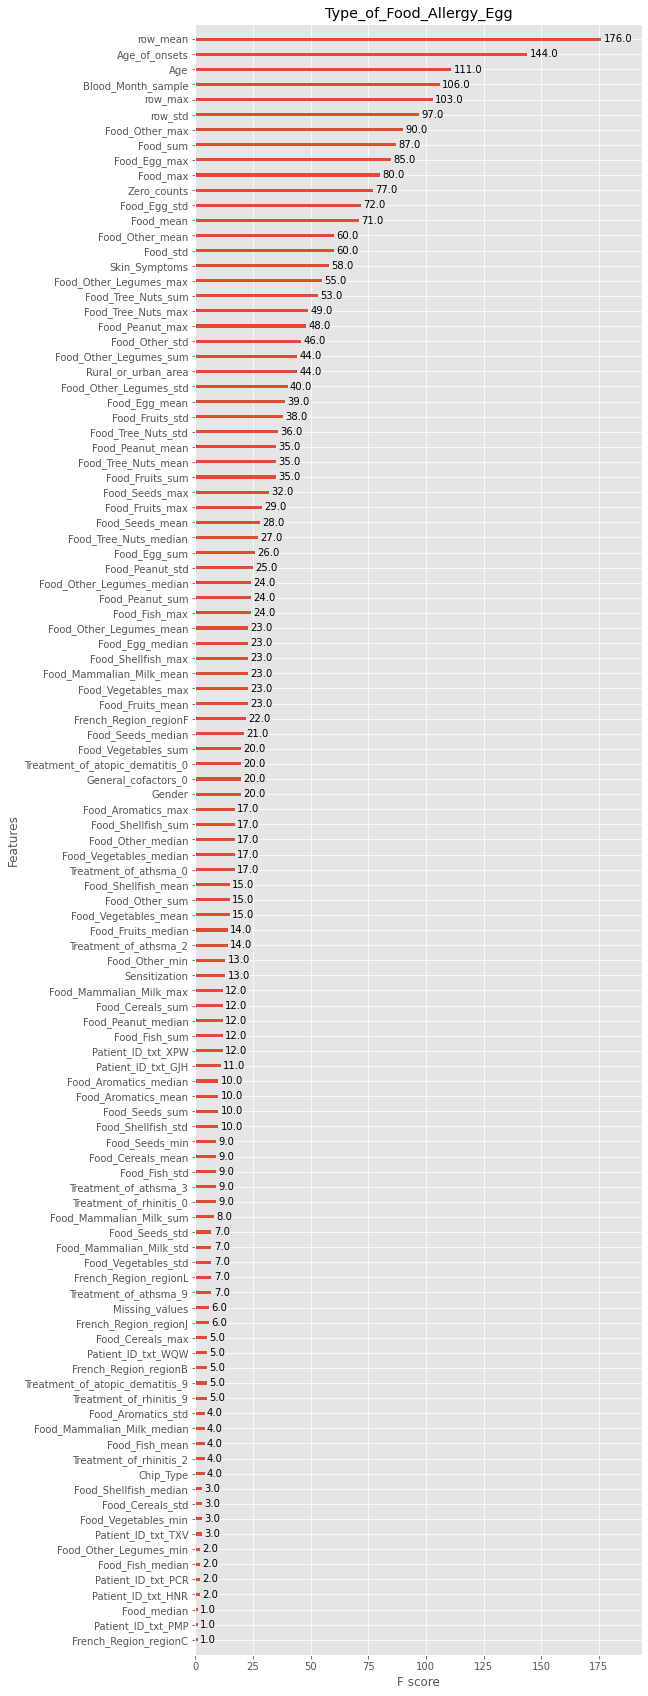

In [40]:
plt.rcParams['figure.figsize'] = (8, 30)
plot_importance(model, title = col)
plt.show()

##### 📢 There are many useless features, which are not helping model.

<h2 align="center">Inference🛰</h3>

In [41]:
test_df = pd.read_csv('./data/test.csv')

In [42]:
submission = {
    'trustii_id': test_df.loc[:, 'trustii_id']
}

for col in tqdm(target_columns):
    submission[col] = [(1 if val >= prob_thresholds[col] else 0) for val in test_preds_all[col]]

100%|██████████| 29/29 [00:00<00:00, 1278.89it/s]


In [43]:
submission = pd.DataFrame(submission)
submission.head()

,trustii_id,Allergy_Present,Severe_Allergy,Respiratory_Allergy,Food_Allergy,Venom_Allergy,Type_of_Respiratory_Allergy_ARIA,Type_of_Respiratory_Allergy_CONJ,Type_of_Respiratory_Allergy_GINA,Type_of_Respiratory_Allergy_IGE_Pollen_Gram,Type_of_Respiratory_Allergy_IGE_Pollen_Herb,Type_of_Respiratory_Allergy_IGE_Pollen_Tree,Type_of_Respiratory_Allergy_IGE_Dander_Animals,Type_of_Respiratory_Allergy_IGE_Mite_Cockroach,Type_of_Respiratory_Allergy_IGE_Molds_Yeast,Type_of_Food_Allergy_Aromatics,Type_of_Food_Allergy_Other,Type_of_Food_Allergy_Cereals_&_Seeds,Type_of_Food_Allergy_Egg,Type_of_Food_Allergy_Fish,Type_of_Food_Allergy_Fruits_and_Vegetables,Type_of_Food_Allergy_Mammalian_Milk,Type_of_Food_Allergy_Oral_Syndrom,Type_of_Food_Allergy_Other_Legumes,Type_of_Food_Allergy_Peanut,Type_of_Food_Allergy_Shellfish,Type_of_Food_Allergy_TPO,Type_of_Food_Allergy_Tree_Nuts,Type_of_Venom_Allergy_ATCD_Venom,Type_of_Venom_Allergy_IGE_Venom
0,1,1,1,1,0,0,0,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,1,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,5,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
submission.to_csv('./Predictions/best_lb_XGB_BCV.csv', index='trustii_id')

In [ ]:
# import pickle

# with open('./Predictions/val_all_XGB.pickle', 'wb') as file:
#     pickle.dump(val_all, file)

# with open('./Predictions/val_preds_all_XGB.pickle', 'wb') as file:
#     pickle.dump(val_preds_all, file)
    
# with open('./Predictions/test_preds_all_XGB.pickle', 'wb') as file:
#     pickle.dump(test_preds_all, file)

## References📖
- Test_Distribution.ipynb (Basically just for testing my ideas. Not well organized :))
- My custom made Allergy to Source mapping excel file
- http://www.allergen.org/index.php
- https://www.medicalexpressclinic.co.uk/public/design/pdf/example-of-alex-allergy-test-result.pdf
- https://www.youtube.com/watch?v=-9Ef5lvrvZ4
- https://www.youtube.com/watch?v=klET1jLVmp4